In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import tensorflow
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
tf.__version__

'2.9.1'

In [3]:
%%cmd
pip install tensorflow

Microsoft Windows [Version 10.0.19045.2728]
(c) Microsoft Corporation. All rights reserved.

D:\gfg_hack>pip install tensorflow



D:\gfg_hack>

In [4]:
data_dir = "dataset_Augmented"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

In [5]:
diseases = os.listdir(train_dir)
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Apple___Apple_scab,2016
Apple___Black_rot,1987
Apple___Cedar_apple_rust,1760
Apple___healthy,2008
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,1642
...,...
Tomato___Tomato_mosaic_virus,1790
Tomato___Tomato_Yellow_Leaf_Curl_Virus,1961
Wheat___Brown_Rust,722
Wheat___Healthy,893


In [6]:
train_datagen= ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)
val_datagen=ImageDataGenerator()
train= train_datagen.flow_from_directory(train_dir,batch_size=128,target_size=(200,200),color_mode='rgb',class_mode='categorical',seed=42)
valid=val_datagen.flow_from_directory(valid_dir,batch_size=128,target_size=(200,200),color_mode='rgb',class_mode='categorical')

Found 91427 images belonging to 62 classes.
Found 21578 images belonging to 62 classes.


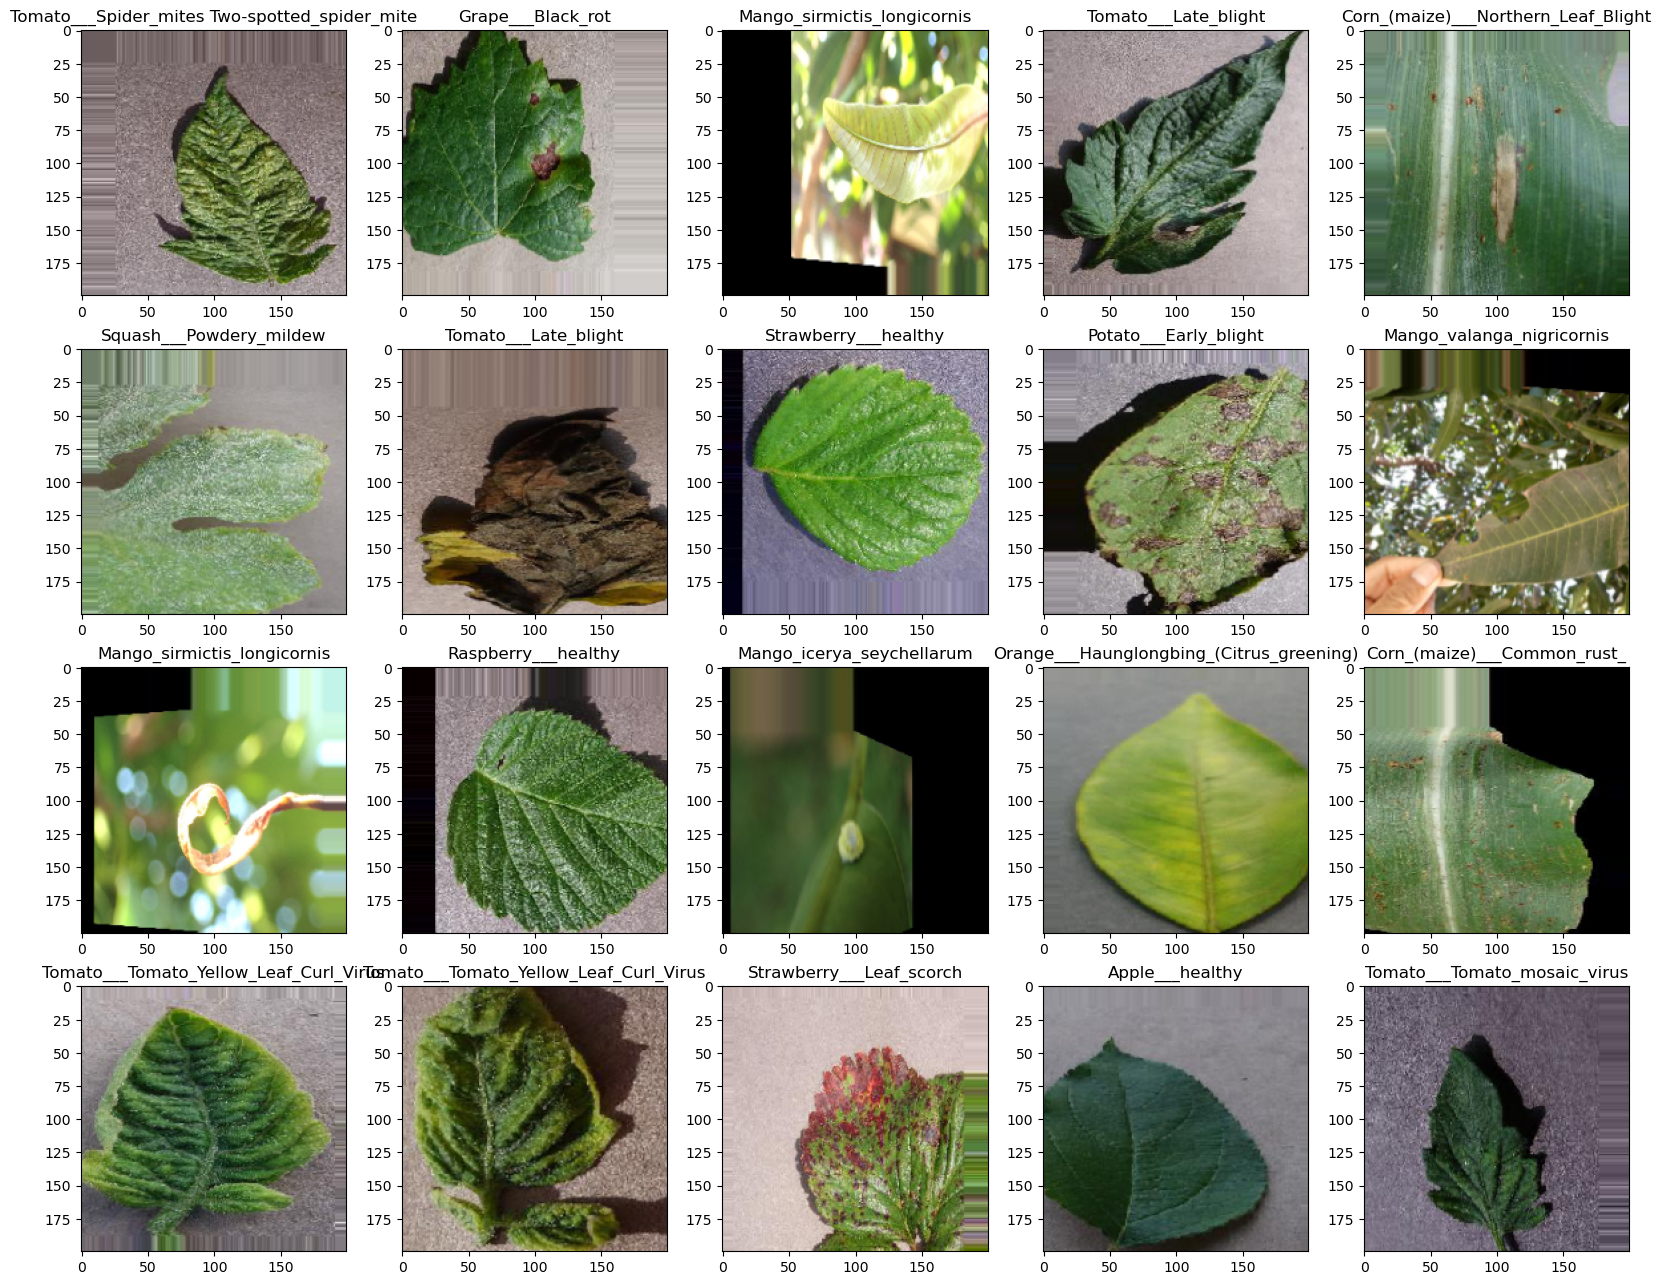

In [7]:
classes=list(train.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train:
    for i in range(0,20):
        plt.subplot(5,5,i+1)
        plt.imshow(X_batch[i].astype(np.uint8))
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    plt.show()
    break

In [8]:
base_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(200,200,3),classes=62)
base_model_tf.trainable=False
pt=Input(shape=(200,200,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) 
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dense(62,activation='softmax')(model_resnet)
Model_v1=Model(inputs=pt,outputs=model_resnet)
Model_v1.summary()
Model: "Model_v1"

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 200, 200, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 200, 200, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 200, 200, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [9]:
Model_v1.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history=Model_v1.fit(train,validation_data=valid,epochs=4,verbose=2,callbacks=[callback])

Epoch 1/4
715/715 - 4572s - loss: 0.5724 - accuracy: 0.8376 - val_loss: 0.2289 - val_accuracy: 0.9253 - 4572s/epoch - 6s/step
Epoch 2/4
715/715 - 1021s - loss: 0.2053 - accuracy: 0.9328 - val_loss: 0.1744 - val_accuracy: 0.9420 - 1021s/epoch - 1s/step
Epoch 3/4
715/715 - 1009s - loss: 0.1637 - accuracy: 0.9459 - val_loss: 0.1685 - val_accuracy: 0.9430 - 1009s/epoch - 1s/step
Epoch 4/4
715/715 - 1122s - loss: 0.1360 - accuracy: 0.9533 - val_loss: 0.1644 - val_accuracy: 0.9435 - 1122s/epoch - 2s/step


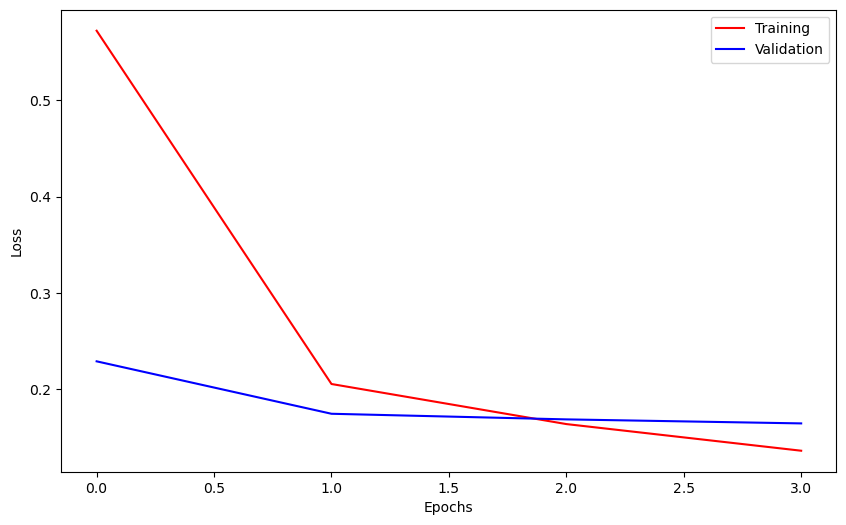

In [10]:
loss =history.history['loss']
val_loss =history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

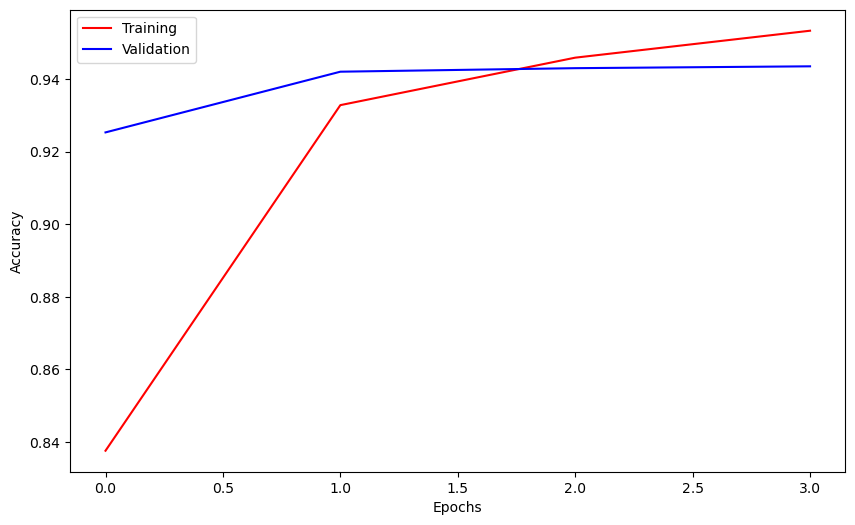

In [11]:
acc =history.history['accuracy']
val_acc =history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [12]:
Model_v1.save("Model_v1_resnet50_4epoch.", save_format='h5')

In [14]:
train.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 4,
 'Corn_(maize)___Common_rust_': 5,
 'Corn_(maize)___Northern_Leaf_Blight': 6,
 'Corn_(maize)___healthy': 7,
 'Grape___Black_rot': 8,
 'Grape___Esca_(Black_Measles)': 9,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 10,
 'Grape___healthy': 11,
 'Mango_apoderus_javanicus': 12,
 'Mango_aulacaspis_tubercularis': 13,
 'Mango_ceroplastes_rubens': 14,
 'Mango_cisaberoptus_kenyae': 15,
 'Mango_dappula_tertia': 16,
 'Mango_healthy': 17,
 'Mango_icerya_seychellarum': 18,
 'Mango_ischnaspis_longirostris': 19,
 'Mango_neomelicharia_sparsa': 20,
 'Mango_orthaga_euadrusalis': 21,
 'Mango_procontarinia_matteiana': 22,
 'Mango_sirmictis_longicornis': 23,
 'Mango_valanga_nigricornis': 24,
 'Orange___Haunglongbing_(Citrus_greening)': 25,
 'Peach___Bacterial_spot': 26,
 'Peach___healthy': 27,
 'Pepper,_bell___Bacterial_spot': 28,
 'Pepper,_be

In [36]:
model = load_model('Model_v1_resnet50_4epoch')
from cv2 import imread
img1 = imread('D:/gfg_hack/dataset_Augmented/test/test/PotatoEarlyBlight1.JPG')
type(img1)

numpy.ndarray

In [37]:
import cv2
img1 = cv2.resize(img1, (200,200))
img1.shape

(200, 200, 3)

In [28]:
import numpy as np
img1_tensor = np.expand_dims(img1, axis=0)
img1_tensor.shape

(1, 200, 200, 3)

In [29]:
pred = model.predict(img1_tensor)

1/1 [==============================] - 0s 21ms/step


In [30]:
pred

array([[3.4963306e-09, 4.5020982e-07, 3.6918824e-09, 5.4859724e-11,
        3.5995358e-09, 7.2493545e-09, 6.0189340e-12, 8.1062188e-09,
        1.3692297e-09, 2.2203078e-07, 3.0633571e-10, 5.2119598e-10,
        1.1370464e-06, 4.0259674e-11, 5.5303657e-13, 5.0041685e-08,
        1.9605422e-05, 1.4620161e-07, 1.0819625e-13, 2.8595866e-06,
        8.8654694e-08, 1.5394173e-06, 5.4837874e-04, 2.6631206e-10,
        8.4395504e-11, 4.5009410e-10, 1.0999216e-09, 1.9672924e-12,
        3.8076355e-06, 8.6344880e-06, 5.7210350e-01, 4.0909597e-01,
        3.2045946e-03, 4.0016761e-11, 2.2243791e-09, 4.7836799e-08,
        2.3383369e-07, 2.9572740e-09, 5.8899408e-13, 1.6412998e-05,
        6.7540931e-11, 4.3696694e-08, 4.8981845e-09, 5.0204358e-06,
        3.1059530e-10, 1.3427386e-09, 3.7873434e-08, 1.6358072e-05,
        3.0753233e-10, 4.9809433e-08, 2.6665838e-03, 2.6413647e-03,
        2.1351065e-07, 2.5220043e-05, 1.7166276e-07, 9.6333092e-03,
        3.8445432e-08, 3.9499687e-06, 7.5020018e

In [31]:
print(np.argmax(pred))

30


In [32]:
fast_pred = model(img1_tensor, training=False)
fast_pred

<tf.Tensor: shape=(1, 62), dtype=float32, numpy=
array([[3.4963286e-09, 4.5020957e-07, 3.6918870e-09, 5.4859693e-11,
        3.5995475e-09, 7.2493505e-09, 6.0189076e-12, 8.1062304e-09,
        1.3692367e-09, 2.2203109e-07, 3.0633787e-10, 5.2119864e-10,
        1.1370502e-06, 4.0259802e-11, 5.5303830e-13, 5.0041852e-08,
        1.9605541e-05, 1.4620235e-07, 1.0819660e-13, 2.8595935e-06,
        8.8654993e-08, 1.5394253e-06, 5.4837996e-04, 2.6631397e-10,
        8.4396587e-11, 4.5009640e-10, 1.0999210e-09, 1.9672913e-12,
        3.8076475e-06, 8.6345162e-06, 5.7210314e-01, 4.0909618e-01,
        3.2046048e-03, 4.0016962e-11, 2.2243865e-09, 4.7836959e-08,
        2.3383446e-07, 2.9572724e-09, 5.8899825e-13, 1.6413038e-05,
        6.7541160e-11, 4.3696755e-08, 4.8981819e-09, 5.0204421e-06,
        3.1059569e-10, 1.3427354e-09, 3.7873487e-08, 1.6358124e-05,
        3.0753156e-10, 4.9809781e-08, 2.6665824e-03, 2.6413761e-03,
        2.1351053e-07, 2.5220028e-05, 1.7166398e-07, 9.6333139e-03,

In [33]:
np.argmax(fast_pred)

30

In [35]:
def process(img_path):
    img = imread(img_path)
    img = cv2.resize(img, (200,200))
    img_tensor = np.expand_dims(img, axis=0)
    fast_pred = model(img_tensor, training=False)
    k = np.argmax(fast_pred)
    
    pass
